In [1]:
!pip install git+https://github.com/fujiisoup/pyspectra.git

import os
from os.path import join
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyspectra
from scipy import interpolate

data_path = join('/', 'Volumes', 'BUFFALO', 'SpectrometerData', '20201208_niihama')
print(os.path.exists(data_path))

  Cloning https://github.com/fujiisoup/pyspectra.git to /private/var/folders/ds/x3jwf2s54c3190fl2p4lrn3w0000gn/T/pip-req-build-h7jo8q6w
  Created wheel for pyspectra: filename=pyspectra-0.0.1-py3-none-any.whl size=18784 sha256=19e01898e879c9d84dda53b56633c180b55eee05cd26a97b4b40160718457730
  Stored in directory: /private/var/folders/ds/x3jwf2s54c3190fl2p4lrn3w0000gn/T/pip-ephem-wheel-cache-phgwcwz3/wheels/f2/02/84/9d89f8a4f86fa15ea48ce7f528a8a47f07613ef90ab688594c
Successfully built pyspectra
False


In [2]:
data_path = join('..', '20201208_niihama')
print(os.path.exists(data_path))

True


In [3]:
file_names = [f'H_{420000 + 5000*i}.nc' for i in range(10)]
data = []
for file_name in file_names:
    data_array = xr.open_dataarray(join(data_path, file_name))
    data_array['motor_coordinate'] = data_array.attrs['motor_coordinate']
    data.append(data_array)
data = xr.concat(data, dim='motor_coordinate')

plasma_data = []
for i, p in enumerate(data['motor_coordinate']):
  d = data.sel(motor_coordinate=p).copy()
  d['long_x'] = d['x'][::-1] - 1000 * i
  d['x'] = data['x']
  plasma_data.append(d.sum('y'))
plasma_data = xr.concat(plasma_data, dim='motor_coordinate')

In [4]:
file_names = [f'back_{420000 + 5000*i}.nc' for i in range(10)]
data = []
for file_name in file_names:
    data_array = xr.open_dataarray(join(data_path, file_name))
    data_array['motor_coordinate'] = data_array.attrs['motor_coordinate']
    data.append(data_array)
data = xr.concat(data, dim='motor_coordinate')

back_data = []
for i, p in enumerate(data['motor_coordinate']):
    d = data.sel(motor_coordinate=p).copy()
    d['long_x'] = d['x'][::-1] - 1000 * i
    d['x'] = data['x']
    back_data.append(d.sum('y'))
back_data = xr.concat(back_data, dim='motor_coordinate')

In [29]:
file_names = [f'sekibun_{420000 + 5000*i}.nc' for i in range(10)]
data = []
for file_name in file_names:
    data_array = xr.open_dataarray(join(data_path, file_name))
    data_array['motor_coordinate'] = data_array.attrs['motor_coordinate']
    data.append(data_array)
data = xr.concat(data, dim='motor_coordinate')

sekibun_data = []
for i, p in enumerate(data['motor_coordinate']):
    d = data.sel(motor_coordinate=p).copy()
    d['long_x'] = d['x'][::-1] - 1000 * i
    d['x'] = data['x']
    sekibun_data.append(d.sum('y'))
sekibun_data = xr.concat(sekibun_data, dim='motor_coordinate')

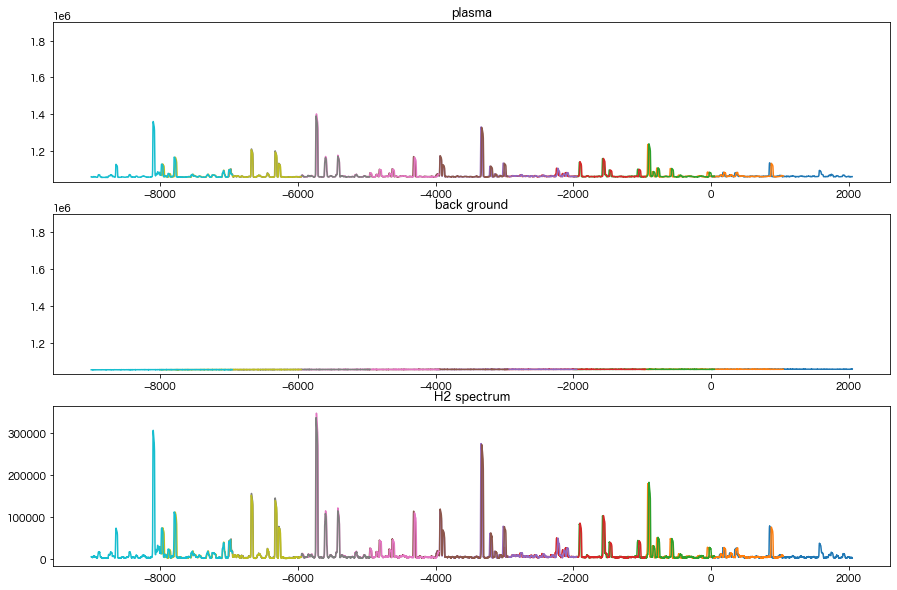

In [5]:
spectrum_data = plasma_data - back_data * 1.0

plt.figure(figsize=[15, 10])
plt.subplot(3, 1, 1)
plt.ylim(1.03*1e6, 1.9*1e6)
plt.title('plasma')
for f in plasma_data:
  plt.plot(f['long_x'], f)

plt.subplot(3, 1, 2)
plt.title('back ground')
plt.ylim(1.03*1e6, 1.9*1e6)
for f in back_data:
  plt.plot(f['long_x'], f)

plt.subplot(3, 1, 3)
plt.title('H2 spectrum')
for f in spectrum_data:
  plt.plot(f['long_x'], f)

# 波長校正

In [6]:
def fit(da):
  popt, perr = pyspectra.fit.singlepeak_fit(da['x'].values, da.values)
  return xr.Dataset({
      'A': popt[0], 'x0': popt[1], 'w': popt[2], 'y0': popt[3],
      'data': da,
      'fit': ('x', pyspectra.profiles.Gauss(da['x'].values, *popt))},
      coords={'x': da['x']})

## Q1

(0.0, 30000.0)

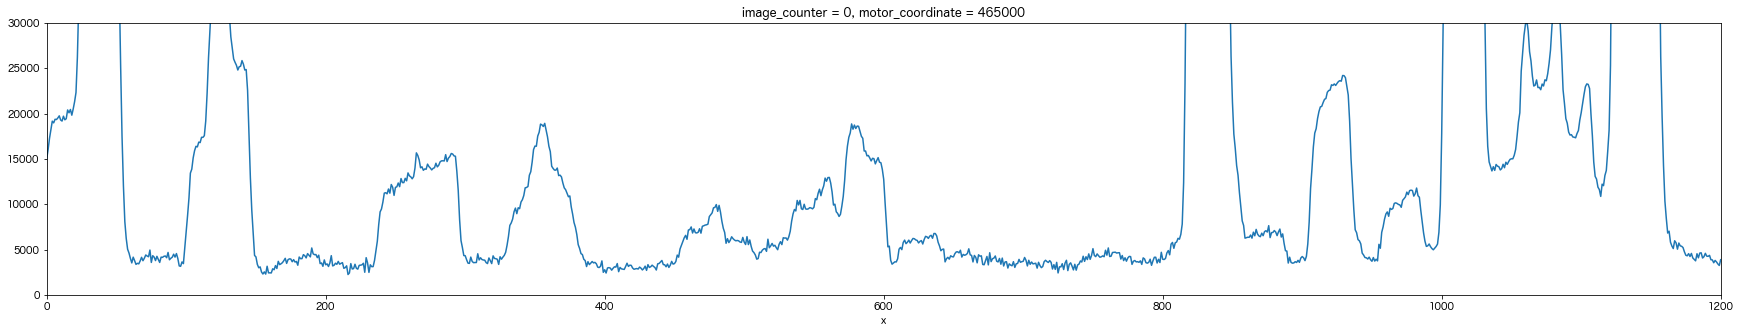

In [7]:
plt.figure(figsize=(30, 5))
spectrum_data.sel(motor_coordinate=465000).plot()
plt.xlim(0, 1200)
plt.ylim(0, 30000)

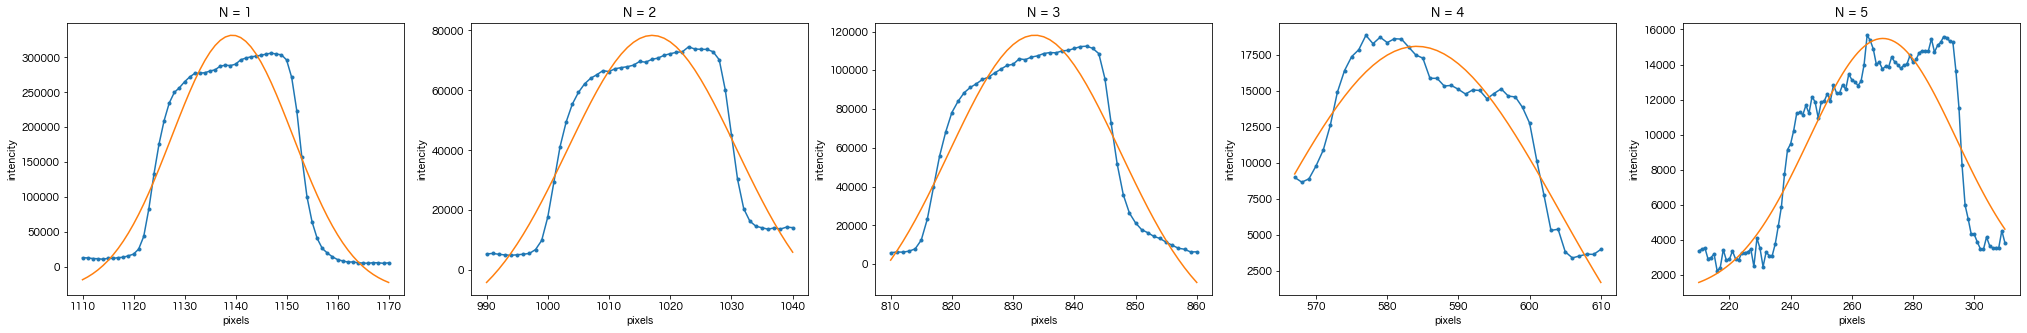

In [8]:
spectrum_lims = [
  [1110, 1170],
  [990, 1040],
  [810, 860],
  [567, 610],
  [210, 310],
#  [240, 280]
]
wave_lengths = [
  601.8299,
  602.3757,
  603.1909,
  604.2716,
  605.6091,
  607.1996,
  609.0374,
  610.9030
]
plt.figure(figsize=(35, 5))
Q1_result = []

for i, lims in enumerate(spectrum_lims):
    result = fit(spectrum_data.sel(motor_coordinate=465000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
    result['v'] = 0
    result['N'] = i+1
    result['wave_length'] = wave_lengths[i]
    result['long_x'] = spectrum_data.sel(motor_coordinate=465000).isel(x=int(result['x0'].values.tolist()))['long_x']
    plt.subplot(1, len(spectrum_lims), i+1)
    result['data'].plot(marker='.')
    result['fit'].plot()
    plt.title('N = {}'.format(i+1))
    plt.xlabel('pixels')
    plt.ylabel('intencity')
    Q1_result.append(result)
Q1_result = xr.concat(Q1_result, dim='N')

Text(0, 0.5, 'area')

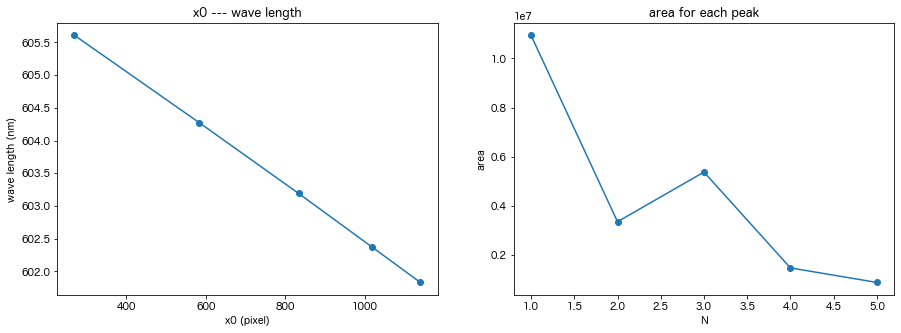

In [9]:
plt.figure(figsize=[15, 5])
plt.subplot(1, 2, 1)
plt.plot(Q1_result['x0'], Q1_result['wave_length'], marker='o')
plt.title('x0 --- wave length')
plt.xlabel('x0 (pixel)')
plt.ylabel('wave length (nm)')
plt.subplot(1, 2, 2)
plt.plot(Q1_result['N'], Q1_result['A'], marker='o')
plt.title('area for each peak')
plt.xlabel('N')
plt.ylabel('area')

## Q2

(0.0, 1000.0)

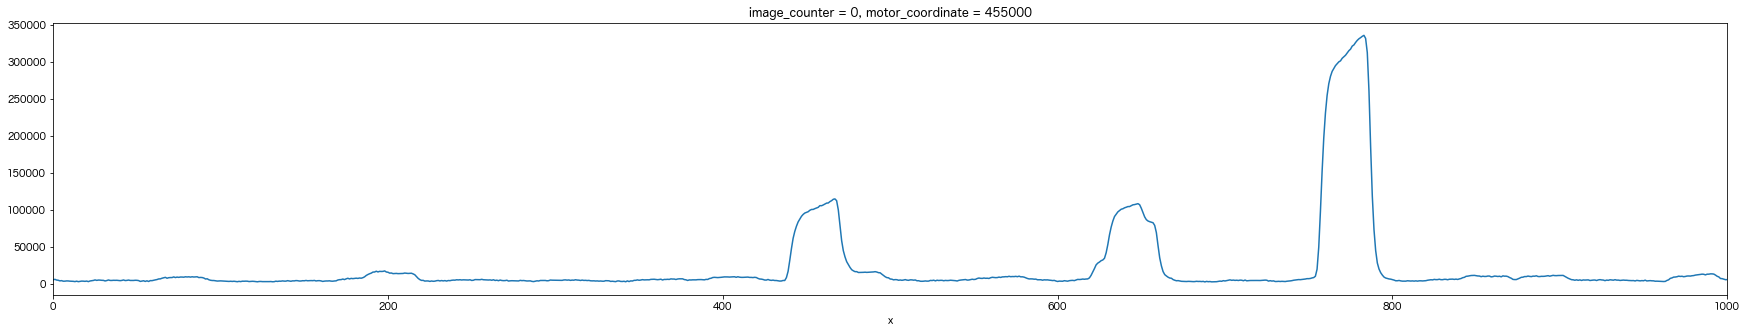

In [10]:
plt.figure(figsize=(30, 5))
spectrum_data.sel(motor_coordinate=455000).plot()
plt.xlim(0, 1000)
#plt.ylim(0, 50000)

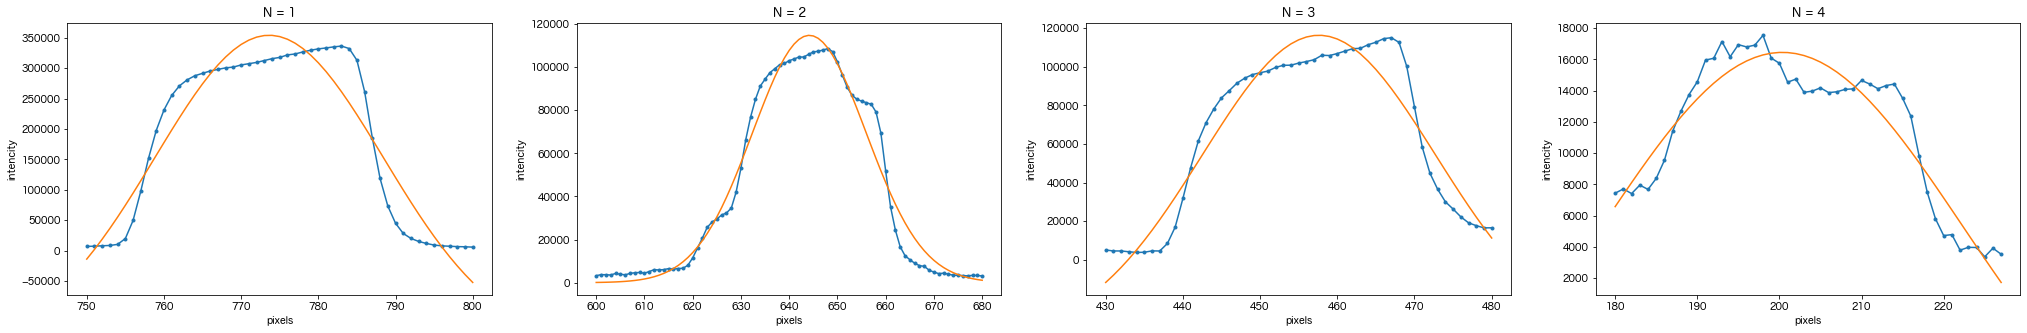

In [11]:
spectrum_lims = [
  [750, 800],
  [600, 680],
  [430, 480],
  [180, 227],
]
wave_lengths = [
  612.1787,
  612.7246,
  613.5395,
  614.6186,
  615.9565
]
plt.figure(figsize=(35, 5))
Q2_result = []

for i, lims in enumerate(spectrum_lims):
    result = fit(spectrum_data.sel(motor_coordinate=455000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
    result['v'] = 0
    result['N'] = i+1
    result['wave_length'] = wave_lengths[i]
    result['long_x'] = spectrum_data.sel(motor_coordinate=455000).isel(x=int(result['x0'].values.tolist()))['long_x']
    plt.subplot(1, len(spectrum_lims), i+1)
    result['data'].plot(marker='.')
    result['fit'].plot()
    plt.title('N = {}'.format(i+1))
    plt.xlabel('pixels')
    plt.ylabel('intencity')
    Q2_result.append(result)
Q2_result = xr.concat(Q2_result, dim='N')

Text(0, 0.5, 'area')

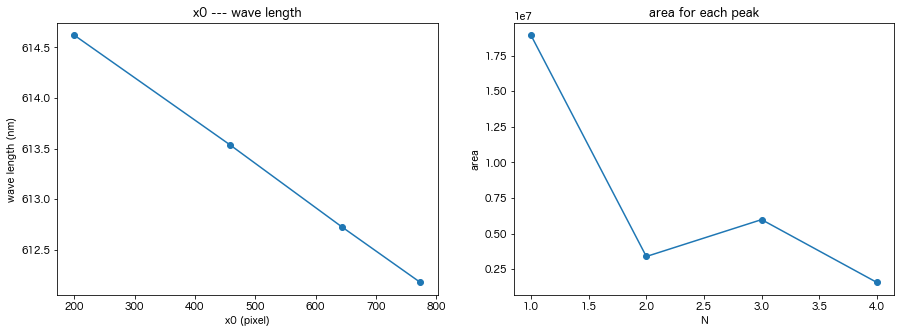

In [12]:
plt.figure(figsize=[15, 5])
plt.subplot(1, 2, 1)
plt.plot(Q2_result['x0'], Q2_result['wave_length'], marker='o')
plt.title('x0 --- wave length')
plt.xlabel('x0 (pixel)')
plt.ylabel('wave length (nm)')
plt.subplot(1, 2, 2)
plt.plot(Q2_result['N'], Q2_result['A'], marker='o')
plt.title('area for each peak')
plt.xlabel('N')
plt.ylabel('area')

## Q3

(0.0, 1000.0)

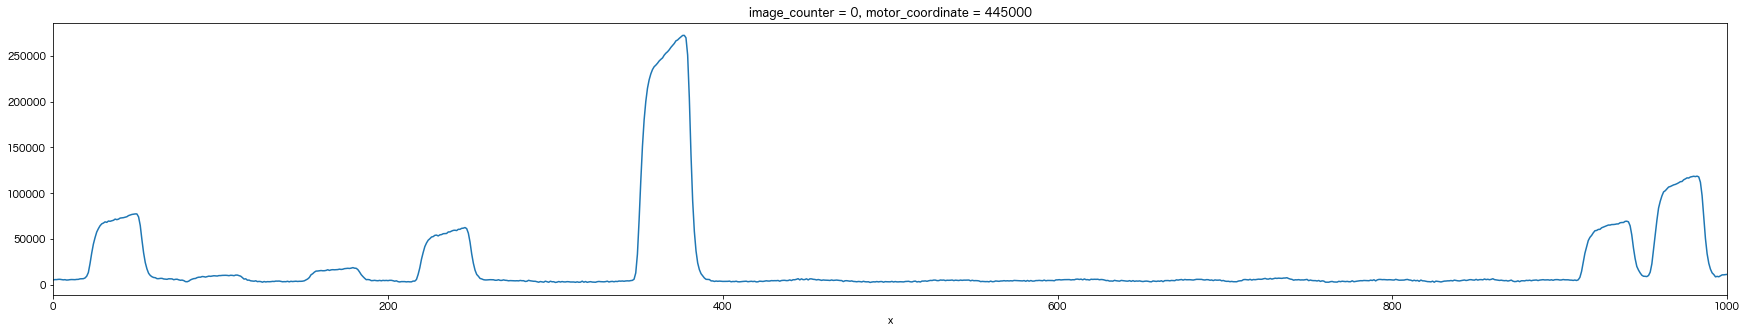

In [13]:
plt.figure(figsize=(30, 5))
spectrum_data.sel(motor_coordinate=445000).plot()
plt.xlim(0, 1000)
#plt.ylim(0, 50000)

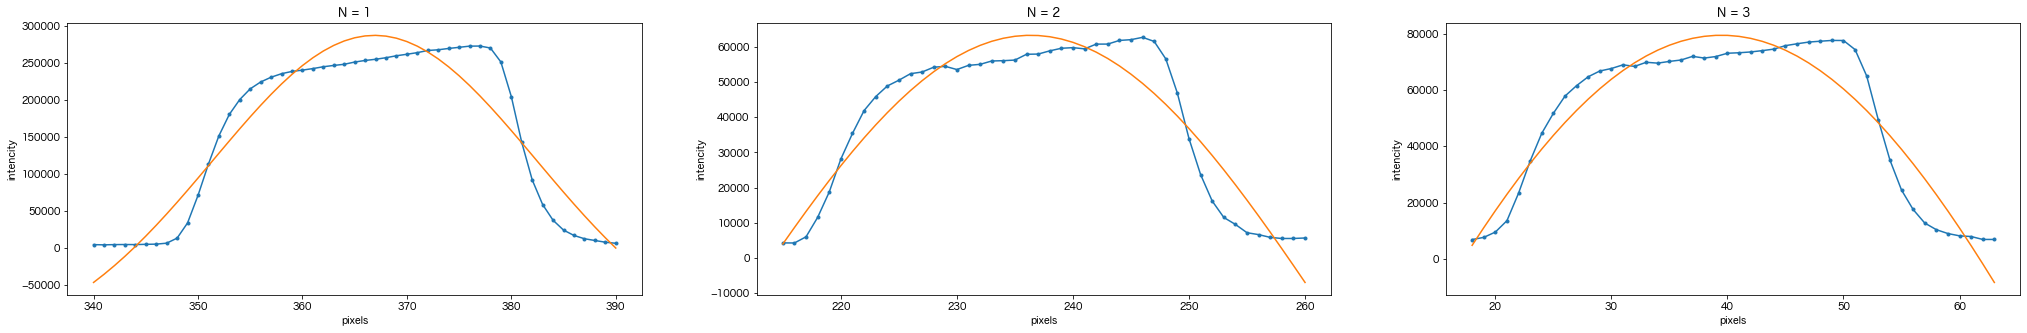

In [14]:
spectrum_lims = [
  [340, 390],
  [215, 260],
  [18, 63],
]
wave_lengths = [
  622.4815,
  623.0258,
  623.8391,
  624.9150,
  626.2495,
  627.8369,
  629.6622,
  631.7233

]
plt.figure(figsize=(35, 5))
Q3_result = []

for i, lims in enumerate(spectrum_lims):
    result = fit(spectrum_data.sel(motor_coordinate=445000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
    result['v'] = 0
    result['N'] = i+1
    result['wave_length'] = wave_lengths[i]
    result['long_x'] = spectrum_data.sel(motor_coordinate=445000).isel(x=int(result['x0'].values.tolist()))['long_x']
    plt.subplot(1, len(spectrum_lims), i+1)
    result['data'].plot(marker='.')
    result['fit'].plot()
    plt.title('N = {}'.format(i+1))
    plt.xlabel('pixels')
    plt.ylabel('intencity')
    Q3_result.append(result)
Q3_result = xr.concat(Q3_result, dim='N')

# ピクセルを波長に変換

Text(0, 0.5, 'wavelength (nm)')

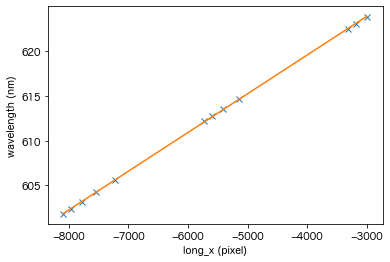

In [15]:
wavelength = np.concatenate([Q1_result['wave_length'].values, Q2_result['wave_length'].values, Q3_result['wave_length'].values])
longx = np.concatenate([Q1_result['long_x'].values, Q2_result['long_x'].values, Q3_result['long_x'].values])

longx_to_wavelength_fun = np.poly1d(np.polyfit(longx, wavelength, 1))
x = np.linspace(-8100, -3000, 100)

plt.plot(longx, wavelength, marker='x', linestyle='None')
plt.plot(x, longx_to_wavelength_fun(x))
plt.xlabel('long_x (pixel)')
plt.ylabel('wavelength (nm)')

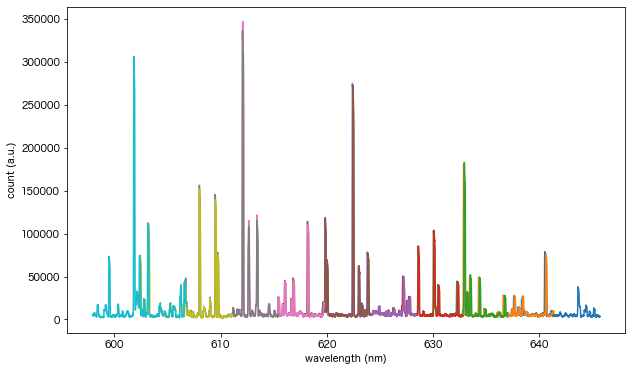

In [32]:
array = []
for a in spectrum_data:
    d = a.assign_coords(wavelength=('x', longx_to_wavelength_fun(a['long_x'])))
    array.append(d)
spectrum_data = xr.concat(array, dim='motor_coordinate')

array = []
for a in sekibun_data:
    d = a.assign_coords(wavelength=('x', longx_to_wavelength_fun(a['long_x'])))
    array.append(d)
sekibun_data = xr.concat(array, dim='motor_coordinate')

plt.figure(figsize=(10, 6))
plt.xlabel('wavelength (nm)')
plt.ylabel('count (a.u.)')
for s in spectrum_data:
    plt.plot(s['wavelength'], s)

# 感度校正
分光器のカウントは、露光時間と放射輝度に比例する

Text(0, 0.5, '放射輝度 ($W m^{-2} nm^{-1} sr^{-1}$)')

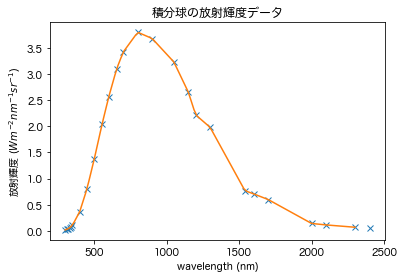

In [28]:
plt.title("積分球の放射輝度データ")
x_value = np.array([300,310,320,330,340,350,400,450,500,555,600,655,700,800,900,1050,1150,1200,1300,1540,1600,1700,2000,2100,2300,2400])
y_value = np.array([1.85e-2,2.80e-2,4.17e-2,5.89e-2,8.08e-2,1.09e-1,3.67e-1,8.03e-1,1.37e-0,2.05e-0,2.56e-0,3.10e-0,3.42e-0,3.80e-0,3.68e-0,3.23e-0,2.65e-0,2.22e-0,1.98e-0,7.69e-1,7.08e-1,6.00e-1,1.42e-1,1.14e-1,6.95e-2,5.01e-2])
plt.plot(x_value, y_value, marker='x', linestyle='None')

sekibun_func = interpolate.interp1d(x_value, y_value, kind='linear')
x = np.linspace(300, 2300, 100)

plt.plot(x, sekibun_func(x))

plt.xlabel("wavelength (nm)")
plt.ylabel(r"放射輝度 ($W m^{-2} nm^{-1} sr^{-1}$)")

In [37]:
sekibun_func(spectrum_data.sel(motor_coordinate=460000)['wavelength']) * spectrum_data.sel(motor_coordinate=460000) / sekibun_data.sel(motor_coordinate=460000)

<xarray.DataArray (x: 2048)>
array([0.00511948, 0.00495589, 0.00454529, ..., 0.02908947, 0.02622417,
       0.02442029])
Coordinates:
    image_counter     int32 0
    motor_coordinate  int64 460000
    long_x            (x) int64 -5953 -5954 -5955 -5956 ... -7998 -7999 -8000
  * x                 (x) int64 0 1 2 3 4 5 6 ... 2042 2043 2044 2045 2046 2047
    wavelength        (x) float64 611.1 611.1 611.1 611.1 ... 602.3 602.3 602.3

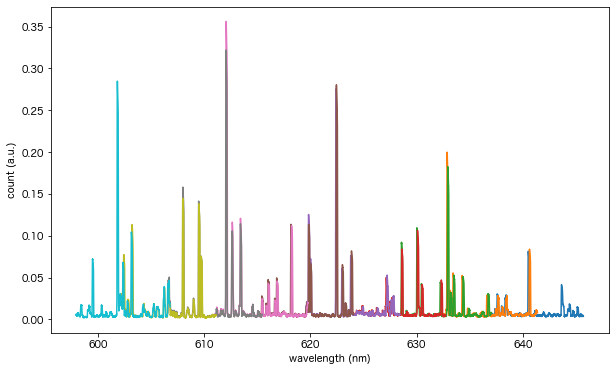

In [39]:
array = []
for a in spectrum_data['motor_coordinate']:
    d = spectrum_data.sel(motor_coordinate=a).assign_coords(true_data=('x', sekibun_func(spectrum_data.sel(motor_coordinate=a)['wavelength']) * spectrum_data.sel(motor_coordinate=a) / sekibun_data.sel(motor_coordinate=a)))
    array.append(d)
spectrum_data = xr.concat(array, dim='motor_coordinate')

plt.figure(figsize=(10, 6))
plt.xlabel('wavelength (nm)')
plt.ylabel('count (a.u.)')
for s in spectrum_data:
    plt.plot(s['wavelength'], s['true_data'])

# ボルツマンフィッティング

(1500.0, 0.0)

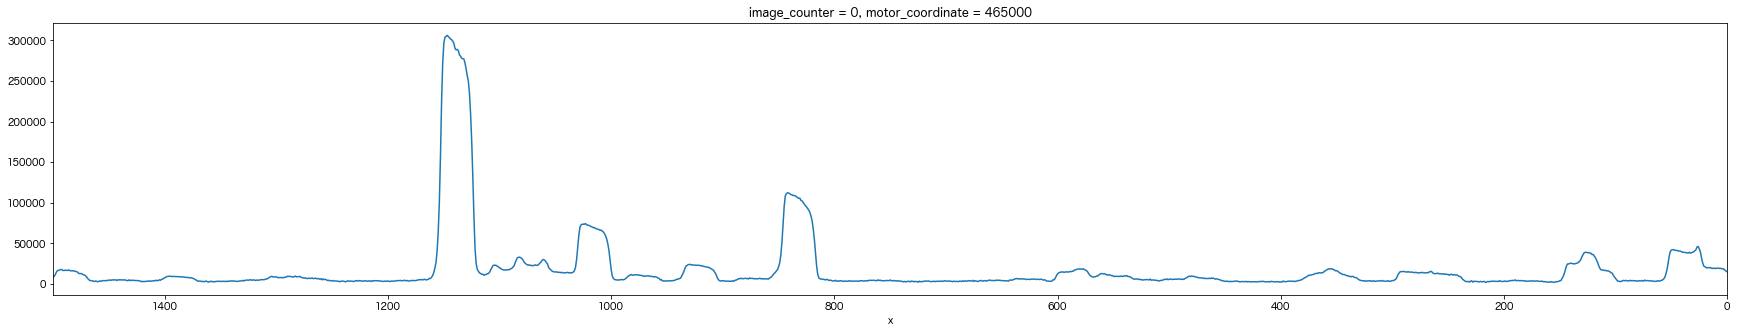

In [18]:
plt.figure(figsize=(30, 5))
spectrum_data.sel(motor_coordinate=465000).plot()
plt.xlim(1500, 0)